Forced Alignment with Wav2Vec2 - Originally written by Moto Hira and modified by Jalal Al-Tamimi
==============================

- Originally written by Moto Hira
- Modified by Jalal Al-Tamimi (September 2025) to include saving outputs to Praat TextGrids
**Author**: `Moto Hira <moto@meta.com>`__

This tutorial shows how to align transcript to speech with
``torchaudio``, using CTC segmentation algorithm described in
`CTC-Segmentation of Large Corpora for German End-to-end Speech
Recognition <https://arxiv.org/abs/2007.09127>`__.

note:

   This tutorial was originally written to illustrate a usecase
   for Wav2Vec2 pretrained model.

   TorchAudio now has a set of APIs designed for forced alignment.
   The `CTC forced alignment API tutorial
   <./ctc_forced_alignment_api_tutorial.html>`__ illustrates the
   usage of :py:func:`torchaudio.functional.forced_align`, which is
   the core API.

   If you are looking to align your corpus, we recommend to use
   :py:class:`torchaudio.pipelines.Wav2Vec2FABundle`, which combines
   :py:func:`~torchaudio.functional.forced_align` and other support
   functions with pre-trained model specifically trained for
   forced-alignment. Please refer to the
   `Forced alignment for multilingual data
   <forced_alignment_for_multilingual_data_tutorial.html>`__ which
   illustrates its usage.


# install required modules

If you are using a system with CPU only (e.g., not CUDA enabled), then follow this link to install a CPU only version of torchaudio: https://pytorch.org/get-started/previous-versions/#v201.
To do so, uncomment the second line below and run it.
And restart the kernel after installation.

In addition, on windows, you might need to install `ffmpeg` separately. Please refer to the official `ffmpeg` installation guide: https://ffmpeg.org/download.html.
After installing, make sure to have added `ffmpeg` to your system path.


In [52]:
# General Python packages
# !pip install IPython matplotlib textgrid pandas

# !pip install torch torchaudio torchvision

# CPU specific Python packages
# !pip install torch==2.7.0 torchvision==0.22.0 torchaudio==2.7.0 --index-url https://download.pytorch.org/whl/cpu

## After restarting the kernell, you need to run the code below to upgrade numpy
# !pip install numpy --upgrade


In [53]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)


2.8.0+cu126
2.8.0+cu126
cpu


# Overview

The process of alignment looks like the following.

1. Estimate the frame-wise label probability from audio waveform
2. Generate the trellis matrix which represents the probability of
   labels aligned at time step.
3. Find the most likely path from the trellis matrix.

In this example, we use ``torchaudio``\ ’s ``Wav2Vec2`` model for
acoustic feature extraction.

# Preparation

First we import the necessary packages, and fetch data that we work on.


In [54]:
from dataclasses import dataclass
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
# here is the address to download the audio file:
# https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav

/tmp/ipython-input-2538953824.py:6: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


# Generate frame-wise label probability

The first step is to generate the label class porbability of each audio
frame. We can use a Wav2Vec2 model that is trained for ASR. Here we use
:py:func:`torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H`.

``torchaudio`` provides easy access to pretrained models with associated
labels.

.. note::

   In the subsequent sections, we will compute the probability in
   log-domain to avoid numerical instability. For this purpose, we
   normalize the ``emission`` with :py:func:`torch.log_softmax`.



In [55]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()
with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE)
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)
emission = emissions[0].cpu().detach()

print(labels)

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


## Visualization


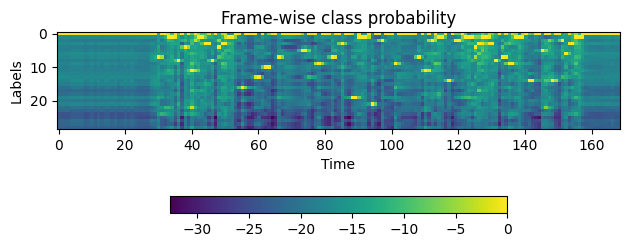

In [56]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(emission.T)
    ax.set_title("Frame-wise class probability")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

# Generate alignment probability (trellis)

From the emission matrix, next we generate the trellis which represents
the probability of transcript labels occur at each time frame.

Trellis is 2D matrix with time axis and label axis. The label axis
represents the transcript that we are aligning. In the following, we use
:math:`t` to denote the index in time axis and :math:`j` to denote the
index in label axis. :math:`c_j` represents the label at label index
:math:`j`.

To generate, the probability of time step :math:`t+1`, we look at the
trellis from time step :math:`t` and emission at time step :math:`t+1`.
There are two path to reach to time step :math:`t+1` with label
:math:`c_{j+1}`. The first one is the case where the label was
:math:`c_{j+1}` at :math:`t` and there was no label change from
:math:`t` to :math:`t+1`. The other case is where the label was
:math:`c_j` at :math:`t` and it transitioned to the next label
:math:`c_{j+1}` at :math:`t+1`.

The following diagram illustrates this transition.

https://download.pytorch.org/torchaudio/tutorial-assets/ctc-forward.png
![https://download.pytorch.org/torchaudio/tutorial-assets/ctc-forward.png](ctc-forward.png)

Since we are looking for the most likely transitions, we take the more
likely path for the value of :math:`k_{(t+1, j+1)}`, that is

:math:`k_{(t+1, j+1)} = max( k_{(t, j)} p(t+1, c_{j+1}), k_{(t, j+1)} p(t+1, repeat) )`

where :math:`k` represents is trellis matrix, and :math:`p(t, c_j)`
represents the probability of label :math:`c_j` at time step :math:`t`.
:math:`repeat` represents the blank token from CTC formulation. (For the
detail of CTC algorithm, please refer to the *Sequence Modeling with CTC*
[`distill.pub <https://distill.pub/2017/ctc/>`__])


We enclose the transcript with space tokens, which represent SOS and EOS.

In [57]:
transcript = "|I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|"
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    trellis = torch.zeros((num_frame, num_tokens))
    trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")

    for t in range(num_frame - 1):
      trellis[t + 1, 1:] = torch.maximum(
        #Score for staying at the same token
        trellis[t, 1:] + emission[t, blank_id],
        #Score for changing to the next token
        trellis[t, :-1] + emission[t, tokens[1:]],
        )
    return trellis


trellis = get_trellis(emission, tokens)

[('|', 1), ('I', 7), ('|', 1), ('H', 8), ('A', 4), ('D', 11), ('|', 1), ('T', 3), ('H', 8), ('A', 4), ('T', 3), ('|', 1), ('C', 16), ('U', 13), ('R', 10), ('I', 7), ('O', 5), ('S', 9), ('I', 7), ('T', 3), ('Y', 19), ('|', 1), ('B', 21), ('E', 2), ('S', 9), ('I', 7), ('D', 11), ('E', 2), ('|', 1), ('M', 14), ('E', 2), ('|', 1), ('A', 4), ('T', 3), ('|', 1), ('T', 3), ('H', 8), ('I', 7), ('S', 9), ('|', 1), ('M', 14), ('O', 5), ('M', 14), ('E', 2), ('N', 6), ('T', 3), ('|', 1)]


## Visualization

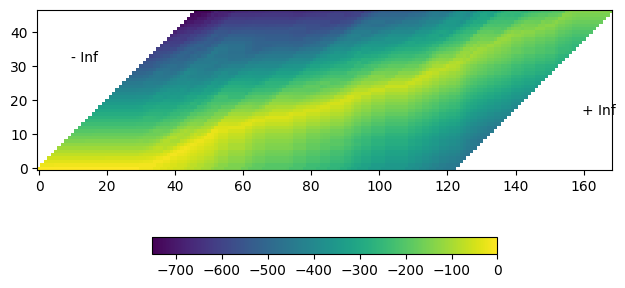

In [58]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(trellis.T, origin="lower")
    ax.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
    ax.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In the above visualization, we can see that there is a trace of high
probability crossing the matrix diagonally.



## Find the most likely path (backtracking)

Once the trellis is generated, we will traverse it following the
elements with high probability.

We will start from the last label index with the time step of highest
probability, then, we traverse back in time, picking stay
(:math:`c_j \rightarrow c_j`) or transition
(:math:`c_j \rightarrow c_{j+1}`), based on the post-transition
probability :math:`k_{t, j} p(t+1, c_{j+1})` or
:math:`k_{t, j+1} p(t+1, repeat)`.

Transition is done once the label reaches the beginning.

The trellis matrix is used for path-finding, but for the final
probability of each segment, we take the frame-wise probability from
emission matrix.



In [59]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float

def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        #Should not happen but just in case
        assert t > 0

        #1. Figure out if the current position was stay or change
        #Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        #Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        #Update position
        t -= 1
        if changed > stayed:
            j -= 1

        #Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    #Now j == 0, which means, it reached the SoS.
    #Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

Point(token_index=0, time_index=0, score=0.9999996423721313)
Point(token_index=0, time_index=1, score=0.9999996423721313)
Point(token_index=0, time_index=2, score=0.9999996423721313)
Point(token_index=0, time_index=3, score=0.9999996423721313)
Point(token_index=0, time_index=4, score=0.9999996423721313)
Point(token_index=0, time_index=5, score=0.9999996423721313)
Point(token_index=0, time_index=6, score=0.9999996423721313)
Point(token_index=0, time_index=7, score=0.9999996423721313)
Point(token_index=0, time_index=8, score=0.9999998807907104)
Point(token_index=0, time_index=9, score=0.9999996423721313)
Point(token_index=0, time_index=10, score=0.9999996423721313)
Point(token_index=0, time_index=11, score=0.9999998807907104)
Point(token_index=0, time_index=12, score=0.9999996423721313)
Point(token_index=0, time_index=13, score=0.9999996423721313)
Point(token_index=0, time_index=14, score=0.9999996423721313)
Point(token_index=0, time_index=15, score=0.9999996423721313)
Point(token_index=

## Visualization

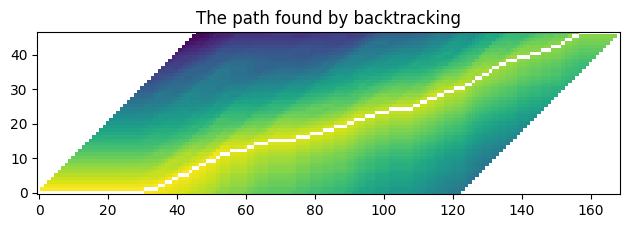

In [60]:
def plot_trellis_with_path(trellis, path):
    #To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path.T, origin="lower")
    plt.title("The path found by backtracking")
    plt.tight_layout()

plot_trellis_with_path(trellis, path)

Looking good.

## Segment the path

Now this path contains repetations for the same labels, so
let’s merge them to make it close to the original transcript.

When merging the multiple path points, we simply take the average
probability for the merged segments.


## Merge the labels

In [61]:
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

|	(1.00): [    0,    31)
I	(0.78): [   31,    35)
|	(0.80): [   35,    37)
H	(1.00): [   37,    39)
A	(0.96): [   39,    41)
D	(0.65): [   41,    44)
|	(1.00): [   44,    45)
T	(0.55): [   45,    47)
H	(1.00): [   47,    49)
A	(0.03): [   49,    52)
T	(1.00): [   52,    53)
|	(1.00): [   53,    56)
C	(0.97): [   56,    61)
U	(1.00): [   61,    63)
R	(0.75): [   63,    67)
I	(0.88): [   67,    75)
O	(0.99): [   75,    79)
S	(1.00): [   79,    83)
I	(0.89): [   83,    86)
T	(0.78): [   86,    90)
Y	(0.70): [   90,    92)
|	(0.66): [   92,    95)
B	(1.00): [   95,    98)
E	(1.00): [   98,   102)
S	(1.00): [  102,   109)
I	(1.00): [  109,   111)
D	(0.93): [  111,   113)
E	(0.66): [  113,   116)
|	(1.00): [  116,   118)
M	(0.67): [  118,   121)
E	(0.67): [  121,   124)
|	(0.49): [  124,   126)
A	(1.00): [  126,   127)
T	(0.50): [  127,   129)
|	(0.51): [  129,   131)
T	(1.00): [  131,   132)
H	(1.00): [  132,   134)
I	(0.75): [  134,   136)
S	(0.36): [  136,   139)
|	(0.50): [  139,   143)


## Visualization


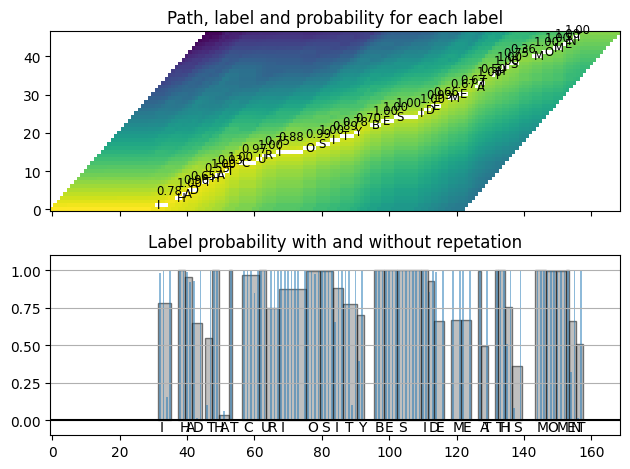

In [62]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07))
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.grid(True, axis="y")
    ax2.set_ylim(-0.1, 1.1)
    fig.tight_layout()


plot_trellis_with_segments(trellis, segments, transcript)

Looks good.

## Merge the segments into words

Now let’s merge the words. The Wav2Vec2 model uses ``'|'``
as the word boundary, so we merge the segments before each occurence of
``'|'``.

Then, finally, we segment the original audio into segmented audio and
listen to them to see if the segmentation is correct.

# Merge words

In [63]:
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

I	(0.78): [   31,    35)
HAD	(0.84): [   37,    44)
THAT	(0.52): [   45,    53)
CURIOSITY	(0.89): [   56,    92)
BESIDE	(0.94): [   95,   116)
ME	(0.67): [  118,   124)
AT	(0.66): [  126,   129)
THIS	(0.70): [  131,   139)
MOMENT	(0.88): [  143,   157)


## Visualization


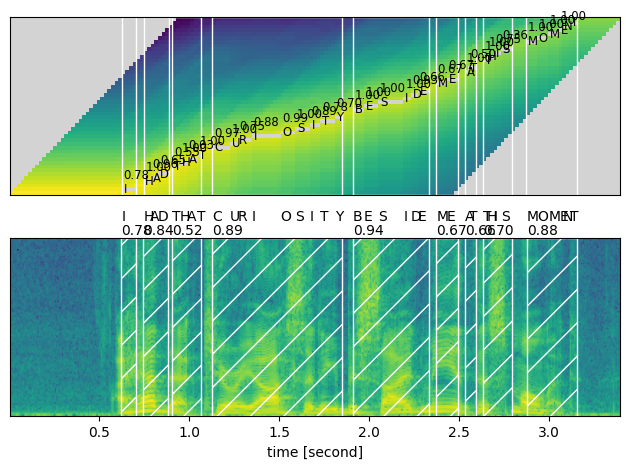

In [64]:
def plot_alignments(trellis, segments, word_segments, waveform, sample_rate=bundle.sample_rate):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1)

    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")
    ax1.set_facecolor("lightgray")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvspan(word.start - 0.5, word.end - 0.5, edgecolor="white", facecolor="none")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    # The original waveform
    ratio = waveform.size(0) / sample_rate / trellis.size(0)
    ax2.specgram(waveform, Fs=sample_rate)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, facecolor="none", edgecolor="white", hatch="/")
        ax2.annotate(f"{word.score:.2f}", (x0, sample_rate * 0.51), annotation_clip=False)

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, sample_rate * 0.55), annotation_clip=False)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    fig.tight_layout()


plot_alignments(
    trellis,
    segments,
    word_segments,
    waveform[0],
)

# Audio Samples


## Generate the audio for full sample

In [65]:
print(transcript)

|I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


In [66]:
IPython.display.Audio(SPEECH_FILE)

## Generate the audio for each segment



In [67]:
def display_segment(i):
    ratio = waveform.size(1) / trellis.size(0)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / bundle.sample_rate:.3f} - {x1 / bundle.sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=bundle.sample_rate)


In [68]:
display_segment(0)

I (0.78): 0.624 - 0.704 sec


In [69]:
display_segment(1)

HAD (0.84): 0.744 - 0.885 sec


In [70]:
display_segment(2)

THAT (0.52): 0.905 - 1.066 sec


In [71]:
display_segment(3)

CURIOSITY (0.89): 1.127 - 1.851 sec


In [72]:
display_segment(4)

BESIDE (0.94): 1.911 - 2.334 sec


In [73]:
display_segment(5)

ME (0.67): 2.374 - 2.495 sec


In [74]:
display_segment(6)

AT (0.66): 2.535 - 2.595 sec


In [75]:
display_segment(7)

THIS (0.70): 2.635 - 2.796 sec


In [76]:
display_segment(8)

MOMENT (0.88): 2.877 - 3.159 sec


# Saving alignment results to csv and TextGrid format

After obtaining forced alignment with wav2vec2, we use the code below to transform the results into a Praat TextGrid. We first save the segments and word segments into a dataframe, then we transform them into a TextGrid format. We do this by separating the `segments` into two levels: word level and segments level. It is of course possible to combine both into one step, without even saving the results into a csv file. However, the code below is intended for exporting the segments from `python` into a csv file in case you are planning on using it with another software or for further processing.

## Word level

### Generate a dataframe

In [77]:
import pandas as pd
word_segments = pd.DataFrame(word_segments)
word_segments.to_csv("word_segments.csv")

### Transform to TextGrid

In [78]:
import csv
# !pip install textgrid
import textgrid # install with pip install textgrid
# Load the CSV data
with open("word_segments.csv",
          "r", encoding="utf-8") as f:
    reader = csv.DictReader(f,
                            delimiter=","
                            )
    data = [row for row in reader]

# Create a TextGrid object
tg = textgrid.TextGrid()

# Create IntervalTier objects
transcript_tier = textgrid.IntervalTier(name="label")
# Populate the interval tiers
for row in data:
  if "label" != "|":
    start_time = (float(row["start"])+(float(row["start"])-0.7))/100
    end_time = (float(row["end"])+(float(row["end"])-0.7))/100
    transcript_tier.add(start_time, end_time, row["label"])

# Add the interval tiers to the TextGrid
tg.append(transcript_tier)

# Write the TextGrid to a file
with open("words.TextGrid", "w", encoding="utf-8") as f:
    tg.write(f)


## segments level

### Generate a dataframe

In [82]:
import pandas as pd
segments = pd.DataFrame(segments)
segments2 = segments[segments.label != "|"]
segments2.to_csv("segments.csv")

### Transform to TextGrid

In [83]:
import csv
import textgrid # install with pip install textgrid
# Load the CSV data
with open("segments.csv",
          "r", encoding="utf-8") as f:
    reader = csv.DictReader(f,
                            delimiter=","
                            )
    data = [row for row in reader]

# Create a TextGrid object
tg = textgrid.TextGrid()

# Create IntervalTier objects
transcript_tier = textgrid.IntervalTier(name="label")
# Populate the interval tiers
for row in data:
  start_time = (float(row["start"])+(float(row["start"])-0.7))/100
  end_time = (float(row["end"])+(float(row["end"])-0.7))/100
  transcript_tier.add(start_time, end_time, row["label"])

# Add the interval tiers to the TextGrid
tg.append(transcript_tier)

# Write the TextGrid to a file
with open("segments.TextGrid", "w", encoding="utf-8") as f:
    tg.write(f)


## Merging the two textgrids

In [84]:
import textgrid # install with pip intall textgrid
# Load the TextGrid files
tg_words = textgrid.TextGrid.fromFile("words.TextGrid")
tg_segments = textgrid.TextGrid.fromFile("segments.TextGrid")
# Merge the two TextGrids
tg_merged = textgrid.TextGrid()
# Add the tiers from both TextGrids
for tier in tg_words.tiers:
    tg_merged.append(tier)
for tier in tg_segments.tiers:
    tg_merged.append(tier)
# Write the merged TextGrid to a file
with open("merged.TextGrid", "w", encoding="utf-8") as f:
    tg_merged.write(f)


# Conclusion

In this tutorial, we looked how to use torchaudio’s Wav2Vec2 model to
perform CTC segmentation for forced alignment.
